In [1]:
import pandas as pd

from multiprocessing import  Pool
from functools import partial
import numpy as np

import os
import io
import json
import boto3
import zipfile
import tarfile
import pandas as pd
from bs4 import BeautifulSoup
import os
import json
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql import udf
from tqdm.notebook import tqdm
from pyspark.sql.types import *
from pyspark.sql.functions import struct

import warnings
warnings.filterwarnings("ignore")

In [2]:
# базовые библиотеки (pandas, numpy, scipy, matplotlib)
import pandas as pd
import openpyxl
import xlsxwriter
import numpy as np
import re
from pprint import pprint
import string
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist

# анализатор морфологии
import pymorphy2

# библиотека nltk (обработка естественных языков)
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer 
from nltk.corpus import stopwords
nltk.download("stopwords")
nltk.download('punkt')

# библиотека scikit-learn (машинное обучение)
from sklearn import metrics 
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer

# библиотека gensim (тематическое моделирование)
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.models import TfidfModel
from gensim.models.ldamulticore import LdaMulticore

nltk.download('wordnet')

%matplotlib inline

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
conf = SparkConf().set('spark.master', 'local[*]')
sc = SparkContext(conf=conf)
spark = SparkSession(sc)
spark

In [4]:
df = pd.read_pickle('shared/parced_sites_lang.pkl')
df.head()

,url,flag,code,file,text,language
1,holodilnik.ru,True,200,mainpages/4e/82/fc/4e82fc971d8437c35c1eca6274...,Холодильник.Ру - интернет-магазин бытовой техн...,ru
3,cherehapa.ru,True,308,mainpages/ef/dc/3d/efdc3d6ddb4d69203a94ab271c...,308 Permanent Redirect 308 Permanent Redirect ...,en
7,nordvpn.com,True,200,mainpages/32/23/67/322367b9334085b76718966fb4...,Best VPN service. Online security starts with ...,en
8,modoza.com,True,200,mainpages/74/3e/f3/743ef358d902290014139b0803...,Итальянская обувь и одежда в Украине – Интерне...,ru
9,eldorado.ru,True,308,mainpages/31/a2/88/31a288bd9f2555e195582f16d9...,308 Permanent Redirect 308 Permanent Redirect ...,en


In [5]:
df_en = df[df['language'] == 'en']
df_en = df_en[:1000] # тестовая выборка на 1000 строк
df_en.head()

,url,flag,code,file,text,language
3,cherehapa.ru,True,308,mainpages/ef/dc/3d/efdc3d6ddb4d69203a94ab271c...,308 Permanent Redirect 308 Permanent Redirect ...,en
7,nordvpn.com,True,200,mainpages/32/23/67/322367b9334085b76718966fb4...,Best VPN service. Online security starts with ...,en
9,eldorado.ru,True,308,mainpages/31/a2/88/31a288bd9f2555e195582f16d9...,308 Permanent Redirect 308 Permanent Redirect ...,en
11,asos.com,True,200,mainpages/67/30/33/673033f05c9688ce1b94052417...,ASOS | Online Shopping for the Latest Clothes ...,en
12,compensair.com,True,308,mainpages/23/7d/22/237d224ab44c4a6b0aa46a6697...,308 Permanent Redirect 308 Permanent Redirect ...,en


In [6]:
# создает спарк датафрейм
spark_df = spark.createDataFrame(df_en)
print(spark_df.show(1))

+------------+----+----+--------------------+--------------------+--------+
|         url|flag|code|                file|                text|language|
+------------+----+----+--------------------+--------------------+--------+
|cherehapa.ru|true| 308| mainpages/ef/dc/...|308 Permanent Red...|      en|
+------------+----+----+--------------------+--------------------+--------+
only showing top 1 row

None


## EN Clustering

In [7]:
# подготовка к препроцессингу
lemmatizer = WordNetLemmatizer() # лемматизация
english_stopwords = stopwords.words("english") # английские стопворды

# функция для препроцессинга текста
def preprocess(data):
    for i in data:
        lemmatized_words = list(map(lambda word: lemmatizer.lemmatize(word.lower()), i.split()))
    
        clean_tokens = [word for word in lemmatized_words if not word in english_stopwords]
        clean_tokens = [''.join(c for c in s if c not in string.punctuation) for s in clean_tokens]
        clean_tokens = [x for x in clean_tokens if x != '']
        clean_tokens = [x.lower() for x in clean_tokens]
        joined = ' '.join(clean_tokens)

        return joined

In [8]:
# перебиваем обычную функцию в udf для спарка
from pyspark.sql.types import StringType
pp_func = F.udf(preprocess, StringType())

In [9]:
# запускаем udf на спарк датафрейме
spark_df2 = spark_df.withColumn('processed', pp_func(struct([spark_df['text'] for x in spark_df.columns])))
print(spark_df2.show(5))

+--------------+----+----+--------------------+--------------------+--------+--------------------+
|           url|flag|code|                file|                text|language|           processed|
+--------------+----+----+--------------------+--------------------+--------+--------------------+
|  cherehapa.ru|true| 308| mainpages/ef/dc/...|308 Permanent Red...|      en|308 permanent red...|
|   nordvpn.com|true| 200| mainpages/32/23/...|Best VPN service....|      en|best vpn service ...|
|   eldorado.ru|true| 308| mainpages/31/a2/...|308 Permanent Red...|      en|308 permanent red...|
|      asos.com|true| 200| mainpages/67/30/...|ASOS | Online Sho...|      en|asos online shopp...|
|compensair.com|true| 308| mainpages/23/7d/...|308 Permanent Red...|      en|308 permanent red...|
+--------------+----+----+--------------------+--------------------+--------+--------------------+
only showing top 5 rows

None


In [10]:
# функция для подсчета слов связанных с тревелом
def travel_words(data):
    travel_words = ['ticket','hotel','rent','rental','bus','train','plane','airplane','voucher','travel','trip', 'travel','trip','traveler','booking','schedule','tourist','tour','tourism','visa','country','airport','resort','schengen']
    for i in data:
        count = 0
        for t in i.split():
            if t not in travel_words:
                continue
            else:
                count = count + 1
            
    return count

# перебиваем обычную функцию в udf для спарка
travel_words_func = F.udf(travel_words, IntegerType())

In [11]:
# запускаем udf на спарк датафрейме
spark_df3 = spark_df2.withColumn('travel_count', travel_words_func(struct([spark_df2['processed'] for x in spark_df2.columns])))
print(spark_df3.show(5))

+--------------+----+----+--------------------+--------------------+--------+--------------------+------------+
|           url|flag|code|                file|                text|language|           processed|travel_count|
+--------------+----+----+--------------------+--------------------+--------+--------------------+------------+
|  cherehapa.ru|true| 308| mainpages/ef/dc/...|308 Permanent Red...|      en|308 permanent red...|           0|
|   nordvpn.com|true| 200| mainpages/32/23/...|Best VPN service....|      en|best vpn service ...|           1|
|   eldorado.ru|true| 308| mainpages/31/a2/...|308 Permanent Red...|      en|308 permanent red...|           0|
|      asos.com|true| 200| mainpages/67/30/...|ASOS | Online Sho...|      en|asos online shopp...|           0|
|compensair.com|true| 308| mainpages/23/7d/...|308 Permanent Red...|      en|308 permanent red...|           0|
+--------------+----+----+--------------------+--------------------+--------+--------------------+------

In [12]:
# показываем те домены где каунт > 10
spark_df_final = spark_df3.filter(spark_df3.travel_count > 10)
print(spark_df_final.show(5))

+------------------+----+----+--------------------+--------------------+--------+--------------------+------------+
|               url|flag|code|                file|                text|language|           processed|travel_count|
+------------------+----+----+--------------------+--------------------+--------+--------------------+------------+
|     priceline.com|true| 200| mainpages/66/7d/...|Priceline.com - T...|      en|pricelinecom best...|          26|
|      banggood.com|true| 200| mainpages/ac/ab/...|Banggood: Online ...|      en|banggood online s...|          12|
|babyshopstores.com|true| 200| mainpages/62/d1/...|Baby Products - A...|      en|baby product one ...|          27|
|   nationalcar.com|true| 200| mainpages/61/9d/...|Fast & Convenient...|      en|fast convenient c...|          15|
|      seniority.in|true| 200| mainpages/c8/d3/...|Seniority.in - On...|      en|seniorityin onlin...|          34|
+------------------+----+----+--------------------+--------------------+

In [13]:
# конвертируем в пандас дф
pdf = spark_df_final.toPandas()

In [14]:
# используем TFIDF векторайзер
vectorizer = TfidfVectorizer()
features = vectorizer.fit_transform(pdf['processed'].values)

In [15]:
# K-means алгоритм - выставляем 2 кластера (тревел и не-тревел)
n_clusters = 2
cls = KMeans(n_clusters=n_clusters, random_state=0)
cls.fit(features)

KMeans(n_clusters=2, random_state=0)

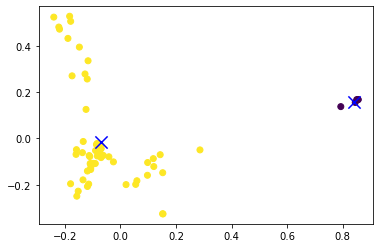

In [16]:
# уменьшаем размерность фич через PCA
pca = PCA(n_components=2, random_state=0) # кол-во компонентов = кол-во кластеров
reduced_features = pca.fit_transform(features.toarray())

reduced_cluster_centers = pca.transform(cls.cluster_centers_)

plt.scatter(reduced_features[:,0], reduced_features[:,1], c=cls.predict(features))
plt.scatter(reduced_cluster_centers[:, 0], reduced_cluster_centers[:,1], marker='x', s=150, c='b')
plt.show()

In [17]:
# предсказания кластеров
pred = cls.predict(features)
# подцепляем предсказания к датасету
pdf['cluster_prediction'] = pred
pdf.head()

,url,flag,code,file,text,language,processed,travel_count,cluster_prediction
0,priceline.com,True,200,mainpages/66/7d/29/667d29477baf1fd14622289b87...,"Priceline.com - The Best Deals on Hotels, Flig...",en,pricelinecom best deal hotels flight rental ca...,26,1
1,banggood.com,True,200,mainpages/ac/ab/5c/acab5c48894d03ebc8e6909ead...,"Banggood: Online Shopping for RC Cars, 3D Prin...",en,banggood online shopping rc cars 3d printer ap...,12,1
2,babyshopstores.com,True,200,mainpages/62/d1/b1/62d1b1267e09c47c0ff64c6645...,Baby Products - A One Stop Shop for all your C...,en,baby product one stop shop childs need babysho...,27,1
3,nationalcar.com,True,200,mainpages/61/9d/7f/619d7f3eb8fd0622bfc7e4201a...,"Fast & Convenient Car Rental at 1,500+ Locatio...",en,fast convenient car rental 1500 location natio...,15,1
4,seniority.in,True,200,mainpages/c8/d3/e7/c8d3e70f35da61a3c4b934ffc0...,Seniority.in - Online Shopping for Senior Citi...,en,seniorityin online shopping senior citizen buy...,34,1


In [19]:
# похоже что кластер 1 относится к тревелу (по большей части)
pdf[pdf['cluster_prediction'] == 1]

,url,flag,code,file,text,language,processed,travel_count,cluster_prediction
0,priceline.com,True,200,mainpages/66/7d/29/667d29477baf1fd14622289b87...,"Priceline.com - The Best Deals on Hotels, Flig...",en,pricelinecom best deal hotels flight rental ca...,26,1
1,banggood.com,True,200,mainpages/ac/ab/5c/acab5c48894d03ebc8e6909ead...,"Banggood: Online Shopping for RC Cars, 3D Prin...",en,banggood online shopping rc cars 3d printer ap...,12,1
2,babyshopstores.com,True,200,mainpages/62/d1/b1/62d1b1267e09c47c0ff64c6645...,Baby Products - A One Stop Shop for all your C...,en,baby product one stop shop childs need babysho...,27,1
3,nationalcar.com,True,200,mainpages/61/9d/7f/619d7f3eb8fd0622bfc7e4201a...,"Fast & Convenient Car Rental at 1,500+ Locatio...",en,fast convenient car rental 1500 location natio...,15,1
4,seniority.in,True,200,mainpages/c8/d3/e7/c8d3e70f35da61a3c4b934ffc0...,Seniority.in - Online Shopping for Senior Citi...,en,seniorityin online shopping senior citizen buy...,34,1
5,timesprime.com,True,200,mainpages/fb/d7/71/fbd771783ae1c89a18c065e131...,"Times Prime: Latest Deals, Coupons, Offers, Ca...",en,time prime latest deals coupons offers cashbac...,15,1
6,bookvip.com,True,200,mainpages/ca/33/dc/ca33dce417e04dc12e83de88ae...,Cheapest Vacation Packages To The Most Popular...,en,cheapest vacation package popular destination ...,69,1
7,booking.com,True,200,mainpages/4d/5d/50/4d5d507758871bb50cea1a208b...,Booking.com | Official site | The best hotels ...,en,bookingcom official site best hotel accommodat...,111,1
8,qeeq.com,True,200,mainpages/51/18/db/5118db007291c248334ffe2539...,Car Rentals Worldwide & Travel Discount | QEEQ...,en,car rental worldwide travel discount qeeqcom €...,20,1
9,italiarail.com,True,200,mainpages/d0/a3/29/d0a329e73fe8f9442ddc00e2a6...,ItaliaRail - Italy Train Ticket and Rail Pass ...,en,italiarail italy train ticket rail pas expert ...,56,1
